# Análise exploratória dos dados de pagamentos do benefício Bolsa Família realizados de 2018 à 2021

## Questões que vamos analisar: <br>

<ul><li>A quantidade de beneficiários do bolsa familia vem aumentando?<br>
<li>Qual região hoje tem a maior percentual de beneficiários?<br>
<li>Qual região hoje tem a maior média paga por beneficiário?<br>
<li>Algum estado despontou nos pagamentos nesses últimos anos?<br>
<li>O perfil de pagamento do beneficío é o mesmo entre as Regiões?<br>

## Preparação do Ambiente

In [88]:
import requests
import pandas as pd
import time
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
from dotenv import load_dotenv
warnings.filterwarnings('ignore') ##remove warnings
pd.set_option('display.float_format', lambda x: '%.1f' % x) ## trunc valores float na exibição do pandas 
sns.set_palette(sns.color_palette("crest")) ##configuração palette de cores padrão para seaborn
load_dotenv() ##importar variáveis de ambiente

True

## Obtenção dos Dados

### Lista Municípios IBGE

Com a lista de municípios obtidas no site do IBGE, iremos coletar os códigos dos munícipios com 100.000 Habitantes ou mais, vamos limitar dessa forma pois utilizaremos a API do dados.gov para obter as informações do bolsa família desses munícipios, deixando a coleta muito extensa se olharmos para 100% dos municípios Brasileiros, visto que existe uma limitação de requisição por minuto que podemos fazer na API

In [2]:
ibges=pd.read_csv('data/Lista_Municípios_com_IBGE_Brasil_Versao_CSV.csv',sep=';',encoding = "iso-8859-1")

In [3]:
ibges_query=ibges.loc[ibges['População 2010']>=100000]['IBGE7'].to_list()
print('Quantidade de Cidades:',len(ibges_query) )

Quantidade de Cidades: 283


### Dados Bolsa Família

Utilizaremos a api rest do site http://portaldatransparecia.gov.br para coletarmos os dados referente ao pagamento do Bolsa Família.<br>
Vamos fazer requisições com os dados:
<ul><li>Código IBGE do município
<li>Mes/Ano<br></ul>
E a api nos retornará as seguintes informações:
    <ul><li>Quantidade de Beneficiários no mês
    <li>Valor total pago no mês
    <li>Região, nome do município e estado</ul><br>
Como a api tem uma limitação de 180 requisições por minuto foi necessário utilizar um timer entre as requisições para evitar o bloqueio do acesso por 8h (Nos experimentos que fiz consegui esse feito 2x!) <br>
Caso tenham mais curiosidade de entender o funcionamento das APIs do portal de transparência indico a documentação oficial <a href="http://api.portaldatransparencia.gov.br/swagger-ui.html#/Bolsa%20Fam%C3%ADlia/bolsaFamiliaPorMunicipioUsingGET">aqui</a>  e também um artigo sobre o assunto disponível neste <a href="https://medium.com/@viniciusgushiken/como-usar-a-api-do-portal-da-transpar%C3%AAncia-governo-federal-7e480fecafa9">link</a>. 

In [4]:
minha_chave = os.environ['chave_api']  ##importando a chave da API de dentro das variáveis de ambiente
chave = {'chave-api-dados':minha_chave} 

In [5]:
import json
request_total=[]
count=0
max_count = 13584  
f = IntProgress(min=0, max=max_count) # criando um barprogress para visualizarmos o progresso da coleta dos dados
display(f) 
bar=0
for ano in [2018,2019,2020,2021]:
    for ibge in ibges_query:
        for mesAno in range(1,13):
            if count >= 150:
                print('pause')
                time.sleep(50)
                count=0
            url=f'http://api.portaldatransparencia.gov.br/api-de-dados/bolsa-familia-por-municipio?codigoIbge={ibge}&mesAno={ano}{str(mesAno).zfill(2)}&pagina=1'
            request_total= request_total+requests.get(url, verify=True,headers=chave).json() 
            print (mesAno)
            f.value+=1

Vamos transformar a estrutura dos dados coletados de json para DF com essa função muito interessante do pandas *pd.json_normalize()* que já explode todos os subitens em colunas para o nosso dataset

In [6]:
request_df=pd.json_normalize(request_total)

In [7]:
request_df.to_excel('./data/bolsaFamilia2018a2021.xlsx') ##salvando os dados em excel para utilização futura

In [9]:
request_df.head()

,Unnamed: 0,id,dataReferencia,valor,quantidadeBeneficiados,municipio.codigoIBGE,municipio.nomeIBGE,municipio.codigoRegiao,municipio.nomeRegiao,municipio.pais,municipio.uf.sigla,municipio.uf.nome,tipo.id,tipo.descricao,tipo.descricaoDetalhada
0,0,122200970,2018-01-01,407024,2801,1100122,JI-PARANÁ,1,NORTE,BRASIL,RO,RONDÔNIA,1,Bolsa Família,Bolsa Família
1,1,116701409,2018-02-01,401184,2831,1100122,JI-PARANÁ,1,NORTE,BRASIL,RO,RONDÔNIA,1,Bolsa Família,Bolsa Família
2,2,118601724,2018-03-01,400388,2843,1100122,JI-PARANÁ,1,NORTE,BRASIL,RO,RONDÔNIA,1,Bolsa Família,Bolsa Família
3,3,121402258,2018-04-01,379196,2661,1100122,JI-PARANÁ,1,NORTE,BRASIL,RO,RONDÔNIA,1,Bolsa Família,Bolsa Família
4,4,118402432,2018-05-01,366353,2655,1100122,JI-PARANÁ,1,NORTE,BRASIL,RO,RONDÔNIA,1,Bolsa Família,Bolsa Família


### Dados de população 

Como queremos fazer algumas comparações utilizando valores normalizados pela população (per capita) iremos utilizar a estimativa da população anual presente no ftp do IBGE.

In [10]:
populacao2021=pd.read_excel('https://ftp.ibge.gov.br/Estimativas_de_Populacao/Estimativas_2021/estimativa_dou_2021.xls')
populacao2020=pd.read_excel('https://ftp.ibge.gov.br/Estimativas_de_Populacao/Estimativas_2020/estimativa_dou_2020.xls')
populacao2019=pd.read_excel('https://ftp.ibge.gov.br/Estimativas_de_Populacao/Estimativas_2019/estimativa_dou_2019.xls')
populacao2018=pd.read_excel('https://ftp.ibge.gov.br/Estimativas_de_Populacao/Estimativas_2018/estimativa_dou_2018_20181019.xls')

## Limpeza e Preparação dos Dados

In [11]:
populacao2021.rename(columns={"ESTIMATIVAS DA POPULAÇÃO RESIDENTE NO BRASIL E UNIDADES DA FEDERAÇÃO COM DATA DE REFERÊNCIA EM 1º DE JULHO DE 2021": "NM_REGIAO"}, inplace=True)
populacao2020.rename(columns={"ESTIMATIVAS DA POPULAÇÃO RESIDENTE NO BRASIL E UNIDADES DA FEDERAÇÃO COM DATA DE REFERÊNCIA EM 1º DE JULHO DE 2020": "NM_REGIAO"}, inplace=True)
populacao2019.rename(columns={"ESTIMATIVAS DA POPULAÇÃO RESIDENTE NO BRASIL E UNIDADES DA FEDERAÇÃO COM DATA DE REFERÊNCIA EM 1º DE JULHO DE 2019": "NM_REGIAO"}, inplace=True)
populacao2018.rename(columns={"ESTIMATIVAS DA POPULAÇÃO RESIDENTE NO BRASIL E UNIDADES DA FEDERAÇÃO COM DATA DE REFERÊNCIA EM 1º DE JULHO DE 2018": "NM_REGIAO"}, inplace=True)

In [12]:
pop21=populacao2021.loc[(populacao2021['NM_REGIAO'].isin(['Região Nordeste','Região Norte','Região Sul','Região Sudeste','Região Centro-Oeste']))]
pop20=populacao2020.loc[(populacao2020['NM_REGIAO'].isin(['Região Nordeste','Região Norte','Região Sul','Região Sudeste','Região Centro-Oeste']))]
pop19=populacao2019.loc[(populacao2019['NM_REGIAO'].isin(['Região Nordeste','Região Norte','Região Sul','Região Sudeste','Região Centro-Oeste']))]
pop18=populacao2018.loc[(populacao2018['NM_REGIAO'].isin(['Região Nordeste','Região Norte','Região Sul','Região Sudeste','Região Centro-Oeste']))]

In [13]:
pop21['ANO']=2021
pop20['ANO']=2020
pop19['ANO']=2019
pop18['ANO']=2018

In [14]:
populacao_historico=pd.concat([pop21,pop20,pop19,pop18]).drop(columns='Unnamed: 1').reset_index(drop=True)

In [15]:
populacao_historico.rename(columns={'Unnamed: 2':'POPULACAO'},inplace=True)

In [16]:
request_df.drop(columns=['Unnamed: 0','municipio.pais','tipo.descricao','tipo.descricaoDetalhada'],inplace=True)

In [17]:
request_df.columns=['ID','DATA','VALOR_BOLSA','QTD_BENEFICIADOS','COD_IBGE','NM_MUNICIPIO','ID_REGIAO','NM_REGIAO','CD_UF','NM_ESTADO','ID_MUNICIPIO']

In [18]:
request_df['DATA']=pd.to_datetime(request_df['DATA'])

## Criação de Atributos (Feature Engineering)

In [19]:
request_df['ANO']=pd.DatetimeIndex(request_df['DATA']).year

Atribuindo o código do IBGE para cada região para realizarmos o cruzamento com a população

In [20]:
def codigoRegiao(x):
    if x == 'Região Norte':
        return 1
    elif x=='Região Nordeste':
        return 2
    elif x=='Região Sudeste':
        return 3
    elif x=='Região Sul':
        return 4
    elif x=='Região Centro-Oeste':
        return 5
populacao_historico['ID_REGIAO']=populacao_historico['NM_REGIAO'].apply(codigoRegiao)

Em 2021 como só temos dados até julho/21, iremos utilizar o valor projetado para o ano inteiro, faremos uma projeção simples, dividindo a quantidade por 7 e multiplicando por 12, ela será útil para as visões anuais.

In [21]:
def projeta(x):
    if x[0]==2021:
        v=(x[1]/7)*12
        return v.round(0)
    else:
        return x[1]

In [22]:
request_df['VALOR_PROJETADO']=request_df[['ANO','VALOR_BOLSA']].apply(projeta,axis=1)

In [48]:
request_df['QT_BENEFICIADOS_PROJETADO']=request_df[['ANO','QTD_BENEFICIADOS']].apply(projeta,axis=1)

In [23]:
request_df[['ANO','VALOR_BOLSA','VALOR_PROJETADO']].loc[request_df.ANO==2021].head()

,ANO,VALOR_BOLSA,VALOR_PROJETADO
10188,2021,368969,632518.000
10189,2021,329890,565526.000
10190,2021,329319,564547.000
10191,2021,330045,565791.000
10192,2021,330045,565791.000


In [49]:
request_df[['ANO','QTD_BENEFICIADOS','QT_BENEFICIADOS_PROJETADO']].loc[request_df.ANO==2021].head()

,ANO,QTD_BENEFICIADOS,QT_BENEFICIADOS_PROJETADO
10188,2021,2417,4143.429
10189,2021,2553,4376.571
10190,2021,2554,4378.286
10191,2021,2556,4381.714
10192,2021,2556,4381.714


<br><br>
## Data Visualization

### Line Plot

Abaixo podemos ver a evolução mensal da quantidade de beneficiários por Região e também a média do Brasil

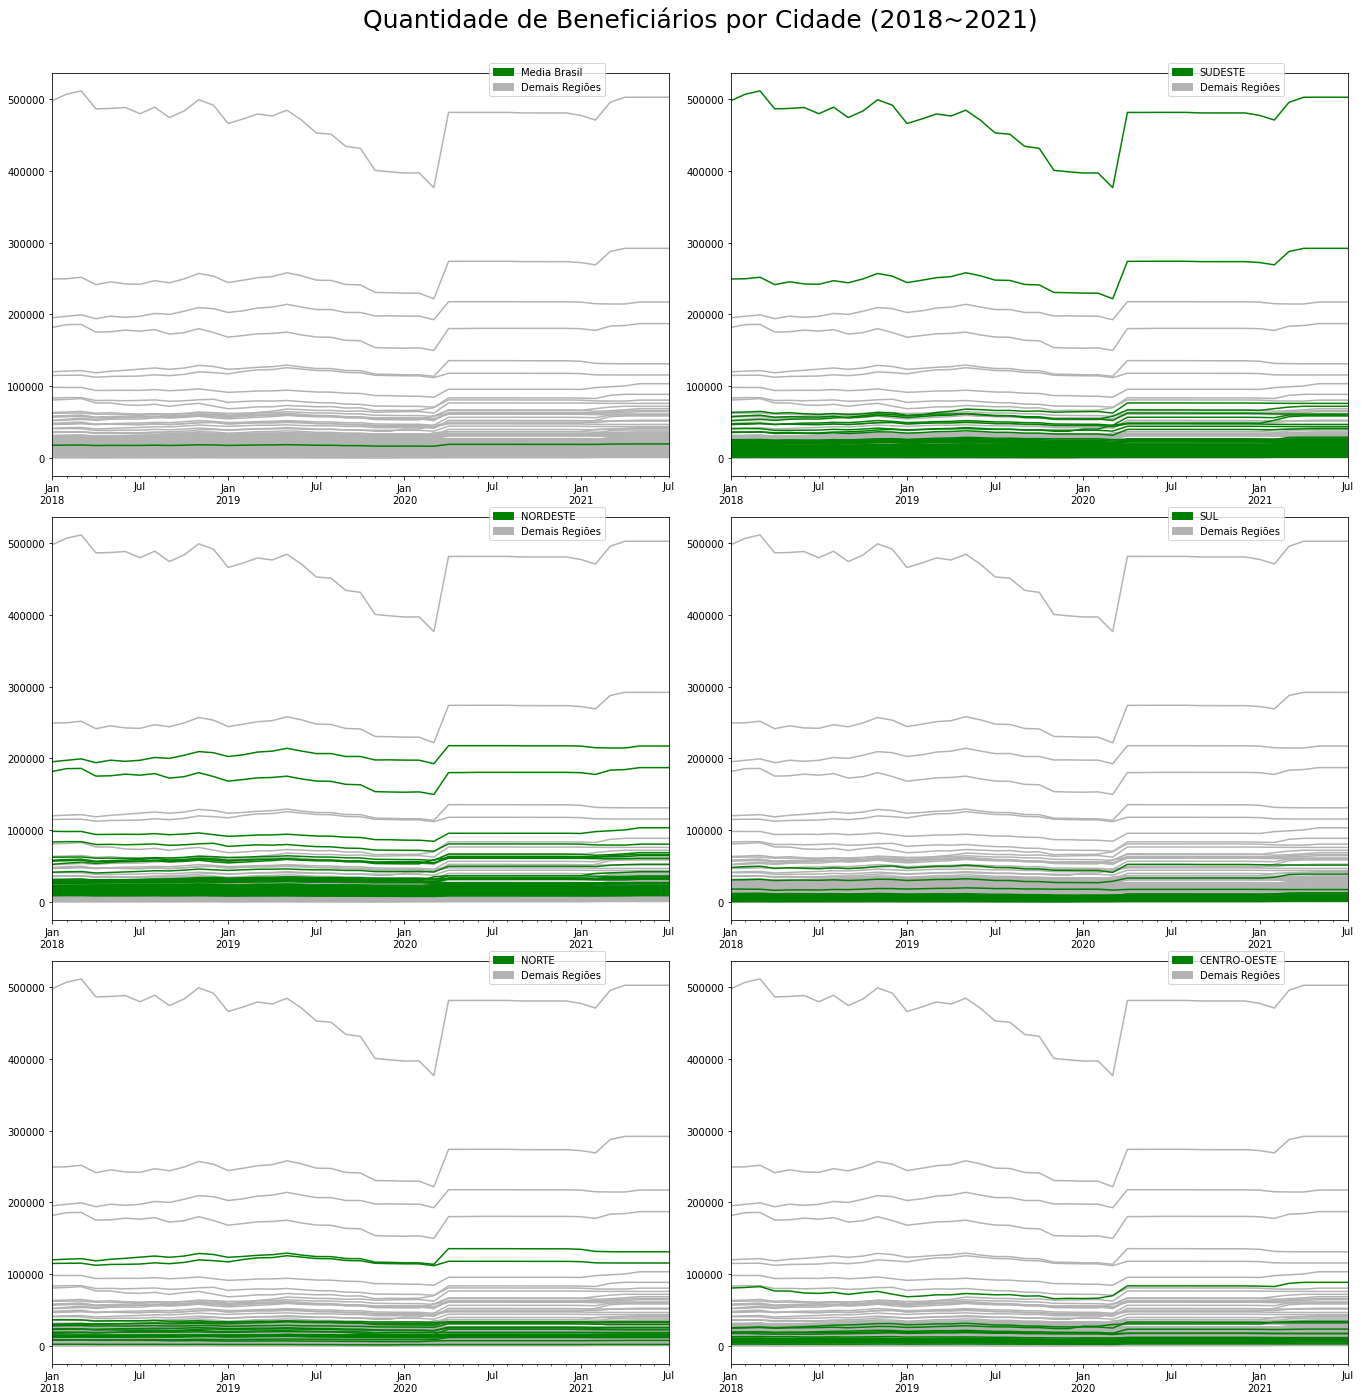

In [85]:
import matplotlib.patches as mpatches
fig, axs = plt.subplots(3,2,figsize=(18,23))
pos=1
pd.pivot_table(request_df[['DATA','NM_MUNICIPIO','QTD_BENEFICIADOS']], index='DATA', columns='NM_MUNICIPIO', values='QTD_BENEFICIADOS').plot(color='0.7',ax=axs.flat[0])#,xticks = range(2018,2022))
pd.pivot_table(request_df[['DATA','NM_MUNICIPIO','QTD_BENEFICIADOS']], index='DATA', columns='NM_MUNICIPIO', values='QTD_BENEFICIADOS').T.mean().plot(color='green',ax=axs.flat[0])#,xticks = range(2018,2022))
patch1 = mpatches.Patch(color='green', label='Media Brasil')
patch2 = mpatches.Patch(color='0.7', label="Demais Regiões")
axs.flat[0].legend(handles=[patch1,patch2],bbox_to_anchor=(0.70, 0.93))
axs.flat[0].axes.get_xaxis().get_label().set_visible(False)
for regiao in ['SUDESTE','NORDESTE','SUL','NORTE','CENTRO-OESTE']:
    pd.pivot_table(request_df.loc[request_df['NM_REGIAO']!=regiao][['DATA','NM_MUNICIPIO','QTD_BENEFICIADOS']], index='DATA', columns='NM_MUNICIPIO', values='QTD_BENEFICIADOS').plot(color='0.7',ax=axs.flat[pos])#,xticks = range(2018,2022))
    pd.pivot_table(request_df.loc[request_df['NM_REGIAO']==regiao][['DATA','NM_MUNICIPIO','QTD_BENEFICIADOS']], index='DATA', columns='NM_MUNICIPIO', values='QTD_BENEFICIADOS').plot(color='green',ax=axs.flat[pos])#,xticks = range(2018,2022))
    patch1 = mpatches.Patch(color='green', label=regiao)
    patch2 = mpatches.Patch(color='0.7', label="Demais Regiões")
    axs.flat[pos].legend(handles=[patch1,patch2],bbox_to_anchor=(0.70, 0.93))
    axs.flat[pos].axes.get_xaxis().get_label().set_visible(False)
    pos+=1
plt.subplots_adjust(left=0, right=1, top=0.88, bottom=0.1,wspace=0.1, hspace=0.1)
fig.suptitle('Quantidade de Beneficiários por Cidade (2018~2021)', y=0.92, fontsize=25)
pass

É possível ver que a região sudeste foi a que mais alavancou o pagamento do auxilio pós pandemia 
<br><br><br>

### Bar Plot

Criaremos abaixo alguns agrupamentos para visualizarmos a evolução anual através do gráfico de barras.

In [45]:
group_mes=request_df.groupby(['DATA','NM_REGIAO']).agg(totalPago=('VALOR_PROJETADO','sum'),totalBeneficiados=('QTD_BENEFICIADOS','sum')).round(5).reset_index().sort_values(by='DATA')

In [47]:
group_mes['mediaPorBeneficiado']=group_mes.totalPago/group_mes.totalBeneficiados

In [58]:
group_ano=request_df.groupby(['ANO','NM_REGIAO','ID_REGIAO']).agg(totalPago=('VALOR_PROJETADO','sum'),totalBeneficiados=('QT_BENEFICIADOS_PROJETADO','sum')).round(5).reset_index().sort_values(by='ANO')

Vamos unir o DF agrupado anualmente com a população que coletamos no FTP do IBGE

In [59]:
group_ano_pop=pd.merge(group_ano, populacao_historico[['ID_REGIAO','ANO','POPULACAO']],  how='left', left_on=['ID_REGIAO','ANO'], right_on = ['ID_REGIAO','ANO'])

In [61]:
group_ano_pop['mediaPorBeneficiado']=group_ano_pop.totalPago/group_ano_pop.totalBeneficiados

In [63]:
group_ano_pop['valorPerCapita']=group_ano_pop.totalPago/group_ano_pop.POPULACAO
group_ano_pop['percentPop']=group_ano_pop.totalBeneficiados/group_ano_pop.POPULACAO

In [64]:
group_ano_pop['valorPerCapita']=pd.to_numeric(group_ano_pop.valorPerCapita)

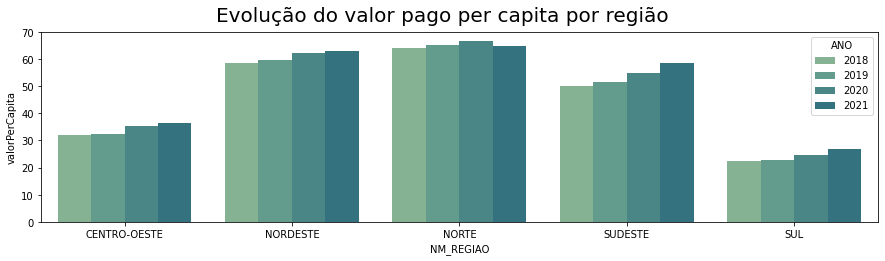

In [81]:
fig, ax = plt.subplots(figsize=(15,3.5))
sns.barplot(data=group_ano_pop, x='NM_REGIAO', y='valorPerCapita',hue='ANO')
fig.suptitle('Evolução do valor pago per capita por região ', fontsize=20)
pass

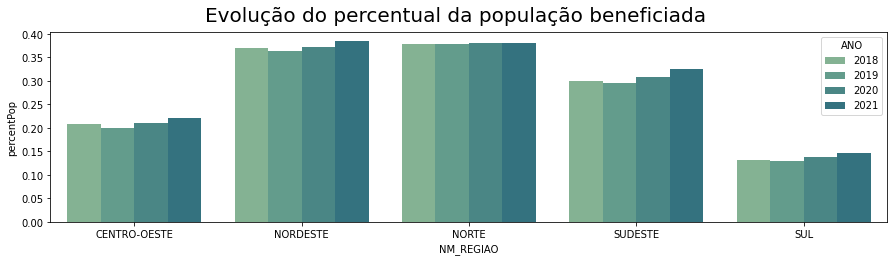

In [91]:
fig, ax = plt.subplots(figsize=(15,3.5))
sns.set_palette(sns.color_palette("crest"))
sns.barplot(data=group_ano_pop, x='NM_REGIAO', y='percentPop',hue='ANO')
fig.suptitle('Evolução do percentual da população beneficiada', fontsize=20)
pass

Como já tínhamos visto na evolução por cidade, quando olhamos em específico a região é visível que as regiões Sul e Sudeste tiveram um aumento expressívo nos pagamento do auxilio.

<br><br>

### Choropleth Map

Criaremos aqui o agrupamento por estado para conseguirmos visualizar a evolução em um mapa corpolético com fronteiras estaduais

In [71]:
group_ano_estado=request_df.groupby(['ANO','CD_UF','ID_REGIAO']).agg(totalPago=('VALOR_PROJETADO','sum'),totalBeneficiados=('QT_BENEFICIADOS_PROJETADO','sum')).round(5).reset_index().sort_values(by='ANO')
group_ano_estado['PAGO_PER_CAPITA']=group_ano_estado.totalPago/group_ano_estado.totalBeneficiados

Para criação do mapa, utilizaremos a biblioteca geopandas <br>
A obtenção do arquivo com as coordenadas e o desenho dos poligonos por estado pode ser obtida no site do IBGE atraves deste caminho:<br>
<b>Geociências -> Downloads -> cartas_e_mapas -> bases_cartograficas_continuas-> bcim -> versao2016 -> geopackage</b> <br>

In [72]:
# !pip install geopandas

In [35]:
import geopandas as gpd
info_ufs=gpd.read_file('./data/bcim_2016_21_11_2018.gpkg', layer='lim_unidade_federacao_a')
info_ufs.rename({'sigla':'CD_UF'},axis=1,inplace=True)
mapa=info_ufs.merge(group_ano_estado[['CD_UF','ANO','PAGO_PER_CAPITA']],on='CD_UF',how='left')

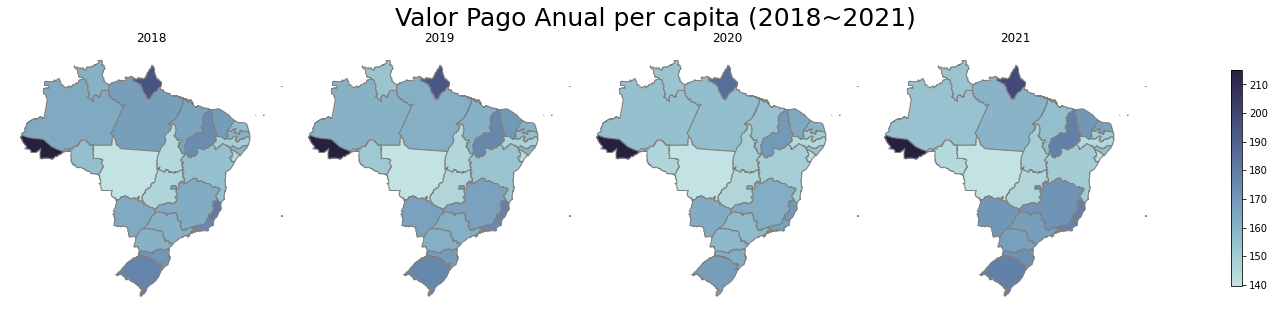

In [83]:
fig, axs = plt.subplots(1,4,figsize=(20,5))
flat=0
for ano in [2018,2019,2020,2021]:
    mapa.loc[mapa['ANO']==ano].plot(column='PAGO_PER_CAPITA',cmap=sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True), ax=axs.flat[flat],edgecolor='grey')
    axs.flat[flat].title.set_text(f'{ano}')
    axs.flat[flat].axis('off')
    flat+=1
plt.subplots_adjust(left=0, right=1, top=0.85, bottom=0.1,wspace=0, hspace=0.2)
patch_col = axs[0].collections[0]
cb = fig.colorbar(patch_col, ax=axs, shrink=0.8)
fig.suptitle('Valor Pago Anual per capita (2018~2021)', y=0.95,x=0.45,fontsize=25)
pass

É possível ver que houve uma queda dos pagamentos em 2020 quando comparamos com 2019, muito puxado pelas alterações nas regras de concessão do benefício que impactaram o primeiro trimestre de 2020, já em 2021, com o ano inteiro dentro do caos que a pandemia gerou, podemos ver o aumento considerável no pagamento deste benefício. Principalmente nos estados da região Sul, Sudeste, Centro-Oeste e Nordeste.<br><br><br>

### Violin Plot

Abaixo utilizaremos , um gráfico chamado de Violino, que mostra os contornos do famoso Boxplot, nossa intenção é visualizar de maneira simples a distribuição que temos entre os valores pago por habitante nas cidades em cada região

In [43]:
group_ano_municipio_estado=request_df.groupby(['ANO','CD_UF','NM_REGIAO','ID_REGIAO']).agg(totalPago=('VALOR_BOLSA','sum'),totalBeneficiados=('QTD_BENEFICIADOS','sum')).round(5).reset_index().sort_values(by='ANO')
group_ano_municipio_estado['PAGO_PER_CAPITA']=group_ano_municipio_estado.totalPago/group_ano_municipio_estado.totalBeneficiados

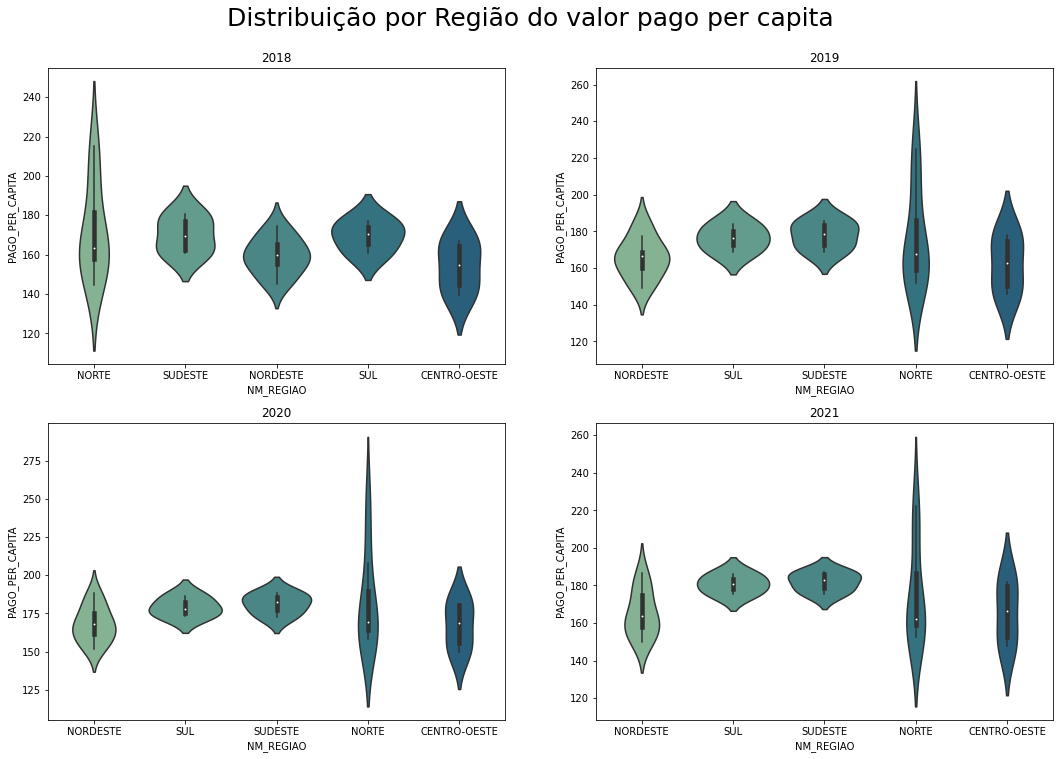

In [87]:
fig, axs = plt.subplots(2,2,figsize=(18,12))
flat=0
for ano in [2018,2019,2020,2021]:
    sns.violinplot(x="NM_REGIAO", y="PAGO_PER_CAPITA", data=group_ano_municipio_estado.loc[group_ano_municipio_estado['ANO']==ano],ax=axs.flat[flat])
    axs.flat[flat].title.set_text(f'{ano}')
    flat+=1
fig.suptitle('Distribuição por Região do valor pago per capita ', y=0.95,fontsize=25)
pass

Como podemos ver, as regiões Norte, Nordeste e Centro-Oeste tem uma distribuição mais espalhada da média de valores pagos por cidade, o que é um forte indicativo de uma maior desigualdade econômica entre os municípios visto que um dos fatores para cálculo do valor pago por família é a classificação de extrema pobreza.

## Conclusões

<ul><li><b>Quantidade de beneficiários do bolsa familia vem aumentando?</b><br>
    <i>Sim, principalmente pós pandemia onde com excessão do norte todas as outras regiões aumentaram o valor pago e também o % de pessoas beneficiadas com o auxilio 
<br><br>
        
<li><b>Qual região hoje tem a maior percentual da sua população beneficiada com o auxílio?</b><br>
    <i> Hoje quem tem o maior percentual são as regiões Norte e Nordeste <br><br>
<li><b>Qual região hoje paga mais por habitante?</b><br>
    <i>Norte e nordeste também são os que mais pagam porém nos últimos anos a região sudeste vem aumentando esse número.<br><br>
<li><b>Algum estado despontou nos pagamentos nesses últimos anos?</b><br>
    <i> Estados do Sul, Sudeste, Centro-oeste foram os que tiveram maior aumento quando comparamos 2021 com 2020<br><br>
<li><b>O perfil de pagamento do beneficío é o mesmo entre as Regiões?</b><br>
    <i> Não, percebemos que enquanto Sul e Sudeste tem um valor pago por habitante mais concentrado em um valor, as regiões Norte, Centro-oeste e Nordeste possuem um espalhamento maior dos valores pagos, o que pode indicar problemas com desigualdade social e também um descontrole da taxa de natalidade

## Referências

https://rodrigodutcosky.medium.com/mapas-coropl%C3%A9ticos-com-os-estados-do-brasil-em-python-b9b48c6db585 <br><br>
https://medium.com/@viniciusgushiken/como-usar-a-api-do-portal-da-transpar%C3%AAncia-governo-federal-7e480fecafa9 <br><br>
http://api.portaldatransparencia.gov.br/swagger-ui.html#/Bolsa%20Fam%C3%ADlia/bolsaFamiliaPorMunicipioUsingGET <br><br>
https://economia.uol.com.br/noticias/redacao/2021/08/09/novo-bolsa-familia-auxilio-brasil-governo-bolsonaro.htm#:~:text=Hoje%2C%20o%20Bolsa%20Fam%C3%ADlia%20pode,entre%200%20e%2017%20anos<br><br>
https://www.ibge.gov.br/